In [ ]:
import os
import copy
import pickle
import zipfile
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# pytorch for neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
!wget --content-disposition https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download

--2021-11-26 00:15:39--  https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download
Resolving uni-siegen.sciebo.de (uni-siegen.sciebo.de)... 132.252.183.1
Connecting to uni-siegen.sciebo.de (uni-siegen.sciebo.de)|132.252.183.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2249444501 (2.1G) [application/zip]
Saving to: ‘WESAD.zip’

WESAD.zip           100%[===================>]   2.09G  27.9MB/s    in 78s     

2021-11-26 00:16:58 (27.5 MB/s) - ‘WESAD.zip’ saved [2249444501/2249444501]



In [ ]:
# with zipfile.ZipFile('/content/WESAD.zip', 'r') as zip_ref:
#     zip_ref.extractall()

with zipfile.ZipFile('/content/WESAD.zip') as zf:
  for member in tqdm(zf.infolist(), desc='Extracting '):
    zf.extract(member)

Extracting :   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
with (open("/content/WESAD/S3/S3.pkl", "rb")) as openfile:
    data = pickle.load(openfile, encoding='latin1')

signal = data['signal']
labels = data['label'].astype('int')
subject = data['subject']

[0 1 2 3 4 5 6 7]
ACC (4545100, 3)
ECG (4545100, 1)
EMG (4545100, 1)
EDA (4545100, 1)
Temp (4545100, 1)
Resp (4545100, 1)


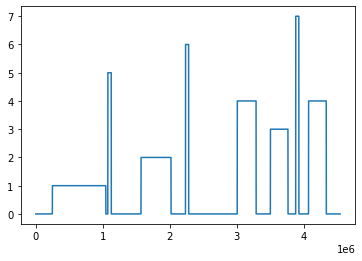

In [ ]:
print(np.unique(labels))
for k,v in signal['chest'].items():
  print(k,v.shape)

plt.plot(labels)

In [ ]:
def normalize(inputs):    #channel wise normalization
  n_samples, n_channels = inputs.shape
  for c in range(n_channels):
    scaler = MinMaxScaler(feature_range=(-1,1)).fit(inputs[:,c].reshape(-1,1)) 
    inputs[:,c] = scaler.transform(inputs[:,c].reshape(-1,1))[:,0]

  return inputs

In [ ]:
inputs = np.concatenate([vals for vals in signal['chest'].values() ], axis=1)
print(inputs.shape)
print(np.unique(labels))

inputs = normalize(inputs)

(4255300, 8)
[0 1 2 3 4 6 7]


In [ ]:
def get_weights(target):
  class_sample_index, class_sample_count = np.unique(labels, return_counts=True)
  weight = 1. / class_sample_count
  samples_weight = np.array([weight[class_sample_index==t][0] for t in tqdm(target)])
  samples_weight = torch.from_numpy(samples_weight)
  return samples_weight

# function to create train and val loaders
def createLoader(inputs, labels, batch_size=32):
  inputs, labels = map(lambda x: torch.from_numpy(x), (inputs, labels))
  dataset = TensorDataset(inputs, labels)
  loader = DataLoader(dataset, batch_size=batch_size)
  return loader


# function to create train and val loaders
def createLoaders(train_inputs, train_labels, batch_size=32, val_percent=.25):
  train_inputs, train_labels = map(lambda x: torch.from_numpy(x), (train_inputs, train_labels))
  train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, test_size=val_percent, random_state=0)
  
  train_dataset = TensorDataset(train_inputs, train_labels)
  samples_weight = get_weights(train_labels.numpy())
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
  train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=None)

  val_dataset = TensorDataset(val_inputs, val_labels)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  dataloaders = {"train":train_loader, "val":val_loader}
  return dataloaders

dataloaders = createLoaders(inputs, labels, batch_size=1000)

  0%|          | 0/3191475 [00:00<?, ?it/s]

In [ ]:
model = nn.Sequential(
          nn.Linear(8,16),
          nn.ReLU(),
          nn.Linear(16,32),
          nn.ReLU(),
          nn.Linear(32,16),
          nn.ReLU(),
          nn.Linear(16,8),
        )

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
model = model.to(device)
print(count_parameters(model))

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

1352


In [ ]:
def trainNet(net,criterion,optimizer,train_loader,val_loader,epochs,check_every=None,earlyStopping=False):

  print("training network")

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  avg_trainLosses = []
  avg_valLosses = []

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []

    net.train()
    for i, (inputBatch,labelBatch) in enumerate(tqdm(train_loader, leave=False, desc='train')):

        inputBatch = inputBatch.to(device).float()
        labelBatch = labelBatch.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        train_loss.append(loss.item())

        # backward + optimize
        loss.backward()
        optimizer.step()

    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(tqdm(val_loader, leave=False, desc='val')):
      with torch.no_grad():

        inputBatch = inputBatch.to(device).float()
        labelBatch = labelBatch.to(device)

        # forward
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())

    avg_trainLoss = np.mean(train_loss)
    avg_valLoss = np.mean(val_loss)
    avg_trainLosses.append(avg_trainLoss)

    if epoch > 0:
      if avg_valLoss < min(avg_valLosses):
        best_params = copy.deepcopy(net.state_dict())
        best_epoch, best_loss = epoch, avg_valLoss
    else:
      movAvg_old = avg_valLoss    
    avg_valLosses.append(avg_valLoss)   

    # print statistics
    if epoch % check_every == check_every - 1:
      print('epoch: %d  | train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss), end="  | ")
      movAvg_new = np.mean(avg_valLosses[epoch+1-check_every:epoch+1])
      print('avg train loss: %.3f, avg val loss: %.3f' % (np.mean(avg_trainLosses[epoch+1-check_every:epoch+1]), movAvg_new))

      if earlyStopping:
        if movAvg_old < movAvg_new:
          break
        else:
          movAvg_old = movAvg_new



  print('Finished Training')
  plt.plot(avg_trainLosses, label='train loss')
  plt.plot(avg_valLosses, label='val loss')
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params

training network


  0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 3  | train loss: 0.135, val loss: 0.131  | avg train loss: 0.220, avg val loss: 0.148


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 6  | train loss: 0.114, val loss: 0.113  | avg train loss: 0.120, avg val loss: 0.118


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 9  | train loss: 0.100, val loss: 0.101  | avg train loss: 0.104, avg val loss: 0.104


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 12  | train loss: 0.093, val loss: 0.093  | avg train loss: 0.095, avg val loss: 0.096


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 15  | train loss: 0.088, val loss: 0.088  | avg train loss: 0.089, avg val loss: 0.090


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 18  | train loss: 0.084, val loss: 0.084  | avg train loss: 0.085, avg val loss: 0.085


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 21  | train loss: 0.080, val loss: 0.080  | avg train loss: 0.081, avg val loss: 0.082


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 24  | train loss: 0.076, val loss: 0.075  | avg train loss: 0.077, avg val loss: 0.076


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 27  | train loss: 0.072, val loss: 0.071  | avg train loss: 0.073, avg val loss: 0.072


train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

train:   0%|          | 0/3192 [00:00<?, ?it/s]

val:   0%|          | 0/1064 [00:00<?, ?it/s]

epoch: 30  | train loss: 0.069, val loss: 0.068  | avg train loss: 0.070, avg val loss: 0.069
Finished Training


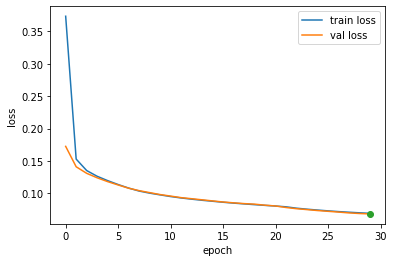

In [ ]:
model.apply(weight_reset)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_params = trainNet(model, criterion, optimizer, dataloaders['train'], dataloaders['val'], epochs=30)

### evaluate

In [ ]:
def evaluate(net, loader):

  net.eval()
  outTrue = []
  outPred = []

  for i, (inputBatch,outTrueBatch) in enumerate(tqdm(loader)):
    with torch.no_grad():

      inputBatch = inputBatch.to(device).float()
      outTrue.extend(outTrueBatch.cpu())

      # forward
      outPredBatch = net(inputBatch).argmax(1)
      outPred.extend(outPredBatch.cpu())

  print(classification_report(outTrue, outPred, digits=4))

In [ ]:
print("evaluation results on train data")
loader = createLoader(inputs, labels, batch_size=1000)
evaluate(model, loader)

evaluation results on train data


  0%|          | 0/4256 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9846    0.9612    0.9728   2142701
           1     0.9986    0.9922    0.9953    800800
           2     0.9405    0.9691    0.9546    430500
           3     0.9479    0.9826    0.9650    253400
           4     0.9485    0.9930    0.9702    537599
           6     0.9524    0.9511    0.9517     45500
           7     0.7936    0.9444    0.8625     44800

    accuracy                         0.9728   4255300
   macro avg     0.9380    0.9705    0.9531   4255300
weighted avg     0.9737    0.9728    0.9730   4255300

